In [1]:
import sys
sys.path.append('../')

import pickle

folder = '/local/scratch_2/jls/virac_classifier/variable/edr3_SJ_noalias/'
with open(folder+'variable_classifier_-10.pkl', 'rb') as f:
    var = pickle.load(f)
with open(folder+'variable_training_set_-10.pkl', 'rb') as f:
    var_dataset_scaled = pickle.load(f)
with open(folder+'variable_features_total.pkl', 'rb') as f:
    var_dataset_full = pickle.load(f)
with open(folder+'variable_features_mira.pkl', 'rb') as f:
    mira_features = pickle.load(f)
var_dataset_full = pd.concat([mira_features,var_dataset_full], axis=0, sort=False)
var_dataset_full = var_dataset_full[~var_dataset_full[['sourceid']].duplicated()].reset_index(drop=True)
var_dataset = var_dataset_full.merge(var_dataset_scaled[['sourceid', 'class', 'prob', 'prob_var']], on='sourceid',sort=False)
var_dataset = var_dataset[~var_dataset[['sourceid']].duplicated()].reset_index(drop=True)
var_dataset_full = var_dataset_full[(~var_dataset_full['error'])].reset_index(drop=True)

var_dataset_full.loc[var_dataset_full['var_class']=='MIRA','var_class']='LPV'
var_dataset_full.loc[var_dataset_full['var_class']=='SRV','var_class']='LPV'
var_dataset_full.loc[var_dataset_full['var_class']=='OSARG','var_class']='LPV'
var_dataset_full.loc[var_dataset_full['var_class']=='RRc','var_class']='RRcd'
var_dataset_full.loc[var_dataset_full['var_class']=='RRd','var_class']='RRcd'

var_dataset_lF = var_dataset_full[var_dataset_full['log10_fap_ls']<-10].reset_index(drop=True)

var_dataset.loc[var_dataset['var_class']=='MIRA','var_class']='LPV'
var_dataset.loc[var_dataset['var_class']=='SRV','var_class']='LPV'
var_dataset.loc[var_dataset['var_class']=='OSARG','var_class']='LPV'
var_dataset.loc[var_dataset['var_class']=='RRc','var_class']='RRcd'
var_dataset.loc[var_dataset['var_class']=='RRd','var_class']='RRcd'

/home/jls/.local/lib/python3.5/site-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


In [13]:
from itertools import product
def pplt(displ,figsize,
        include_values=True, cmap=plt.cm.Greys, 
                  ax=None, xticks_rotation='horizontal',
                  values_format=None,colorbar=False):
    fig, ax = plt.subplots(figsize=figsize)

    cm = displ.confusion_matrix
    n_classes = cm.shape[0]
    displ.im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    displ.text_ = None

    cmap_min, cmap_max = displ.im_.cmap(0), displ.im_.cmap(256)

    if include_values:
        displ.text_ = np.empty_like(cm, dtype=object)
        if values_format is None:
            values_format = '.2g'

        # print text with appropriate color depending on background
        thresh = (cm.max() + cm.min()) / 2.0
        for i, j in product(range(n_classes), range(n_classes)):
            color = cmap_max if cm[i, j] < thresh else cmap_min
            displ.text_[i, j] = ax.text(j, i,
                                       format(cm[i, j], values_format),
                                       ha="center", va="center",
                                       color=color)

    if colorbar:
        fig.colorbar(displ.im_, ax=ax)
    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=displ.display_labels,
           yticklabels=displ.display_labels,
           ylabel="True label",
           xlabel="Predicted label")

    ax.set_ylim((n_classes - 0.5, -0.5))
    plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)

    displ.figure_ = fig
    displ.ax_ = ax
    return displ

In [55]:
cll = 'LPV'
np.count_nonzero((var_dataset['class']=='T2CEP')&(var_dataset['var_class']==cll))/np.count_nonzero((var_dataset['var_class']==cll))

0.002631578947368421

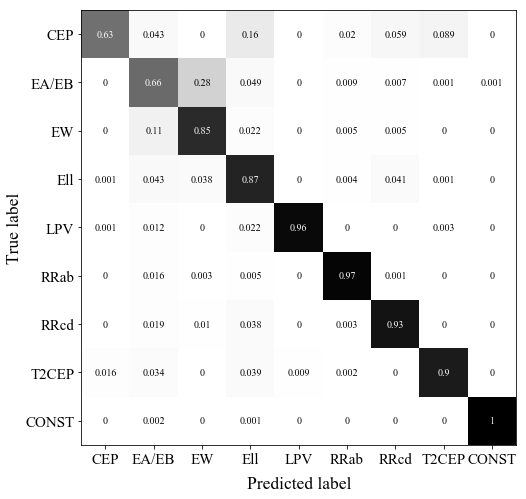

In [236]:
from initial_classif.classifier.classifier import ConfusionMatrixDisplay
CM = np.around(var.cm/np.nansum(var.cm,axis=1)[:,np.newaxis], decimals=3)
cp=np.vstack([CM[0],CM[2:],CM[1]])
cp=np.vstack([cp.T[0],cp.T[2:],cp.T[1]]).T           
               
displ = ConfusionMatrixDisplay(
    confusion_matrix=cp,
        display_labels=['CEP', 'EA/EB', 'EW', 'Ell', 'LPV', 'RRab', 'RRcd', 'T2CEP',
                       'CONST'])
# disp = displ.plot(include_values=True, cmap=plt.cm.Blues, 
#                   ax=None, xticks_rotation='horizontal',
#                   values_format=None,colorbar=False)

displ=pplt(displ,figsize=[8,8])
fig = displ.figure_
ax = displ.ax_
im = displ.im_
fig.set_size_inches(8,8)
ax.set_xlabel('Predicted label',family='serif', fontsize=17.5, labelpad=10)
ax.set_ylabel('True label',family='serif', fontsize=17.5, labelpad=2)
#ax.tick_params(labelsize=15)
import matplotlib
ticks_font = matplotlib.font_manager.FontProperties(family='serif',
                                                            style='normal', size=15,
                                                            weight='normal', stretch='normal')
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)
    
plt.savefig('confusion_matrix.pdf',bbox_inches='tight')

In [33]:
ft=[]
vd=[]
for ii in var.feature_importance.keys():
    if ii[-2:]=='_x':
        ft+=[ii[:-2]]
        vd+=['%0.3f'%np.sqrt(var.feature_importance[ii]*var.feature_importance[ii[:-2]+'_y'])]
    elif ii[-2:]=='_y':
        continue
    else:
        ft+=[ii]
        vd+=['%0.3f'%var.feature_importance[ii]]
asd = np.argsort(np.array(vd))[::-1]
for ii in range(len(vd)):
    print(np.array(ft)[asd][ii],np.array(vd)[asd][ii])

lsq_period 0.081
log10_fap 0.073
model_amplitude 0.062
pow_mean_disp 0.061
amp_double_3 0.055
amp_double_1 0.051
amplitude 0.049
ks_p75_p25_over_error 0.035
JK_col 0.028
max_pow 0.023
ks_mad_over_error 0.021
ks_p95_p5 0.020
phi3_phi1_double 0.018
amp_0 0.017
ks_mad 0.017
amp_double_0 0.016
normed_delta_loglik 0.013
a0_a1 0.012
ks_p84_p16 0.011
peak_ratio_model 0.011
phi1_phi0 0.010
amp_1 0.010
ks_stetson_j 0.010
a0_a2 0.010
a1_a3_double 0.010
a0_a3_double 0.009
Z_model 0.008
a1_a2_double 0.007
ks_eta 0.007
ks_stdev_over_error 0.006
ks_p95_p5_over_error 0.006
a2_a3_double 0.006
ks_p99_p1 0.006
ks_p75_p25 0.006
a0_a1_double 0.006
Y_scale 0.006
J_model 0.006
HK_col 0.006
amp_double_2 0.005
phi2_phi1 0.005
a1_a2 0.005
phi2_phi0 0.005
amp_2 0.005
a0_a3 0.005
ks_p84_p16_over_error 0.005
J_scale 0.005
ks_stetson_i 0.004
a0_a2_double 0.004
ks_p100_p0_over_error 0.004
ks_kurtosis 0.004
Z_scale 0.004
Y_model 0.004
H_model 0.003
ks_skew 0.003
phi3_phi2 0.003
ks_stdev 0.003
ks_p100_p0 0.003
amp_3 

In [3]:
def period_fix(var_in,tol=1.):

    period_out = var_in['lsq_period'].values.copy()

    period_out[((var_in['var_class']=='EA/EB')|(var_in['var_class']=='Ell'))&
                (var_in['amp_0']>tol*var_in['amp_1'])]*=2.
    
    ss=np.argmax([var_in['amp_0'].values,
                  var_in['amp_1'].values,
                  var_in['amp_2'].values,
                  var_in['amp_3'].values],axis=0)
    fltr = ~((var_in['var_class']=='EA/EB')|(var_in['var_class']=='Ell'))
    period_out[fltr]/=(1.+ss)[fltr]
    
    period_out[var_in['var_class']=='EW']*=2
    
    return period_out
    

In [30]:
def add_day_alias_lines_G(centre=np.log10(80.),centre2=np.log10(72.),
                     year_alias_label=False):
    print(year_alias_label)
    xx = np.log10(np.logspace(np.log10(0.001), np.log10(3000.),10000))
    plt.plot(xx, xx, color='gray')
    
    for ii in [1. / 2., 2.]:
        plt.plot(xx, np.log10(ii) + xx, color='k', alpha=0.2, ls='dashed')
        
    xxT, yy = xx.copy(), np.log10(1. / (1. / np.power(10.,xx) + 1. / 1.))
    plt.plot(xxT, yy, color='r', alpha=0.2, ls='dashed')
    xxT, yy = xx.copy(), np.log10(1. / (1. / np.power(10.,xx) - 1. / 1.))
    plt.plot(xxT, yy, color='r', alpha=0.2, ls='dashed')
    
    plt.annotate('1:2',
                 xy=(centre + np.log10(2.), centre),
                 fontsize=12.,
                 rotation=45.,
                 xycoords='data',
                 alpha=0.5)
    
    plt.annotate('2:1',
                 xy=(centre2, centre2 + np.log10(2.)),
                 fontsize=12.,
                 rotation=45.,
                 xycoords='data',
                 alpha=0.5)
    
    if year_alias_label:
        plt.annotate('day alias',
                     xy=(np.log10(.3), np.log10(1. / (1. / .3 + 1. / 1.) + .12)),
                     fontsize=12.,
                     rotation=35.,
                     xycoords='data',
                     alpha=0.5,
                     color='r')
        plt.annotate('day alias',
                     xy=(np.log10(.3), np.log10(1. / (1. / .3 - 1. / 1.) + .12)),
                     fontsize=12.,
                     rotation=52.,
                     xycoords='data',
                     alpha=0.5,
                     color='r')

In [31]:
def add_double_lines(centre,centre2):
    
    xx = np.log10(np.logspace(np.log10(0.001), np.log10(3000.),10000))
    plt.plot(xx, xx, color='gray')
    
    for ii in [1. / 2., 2.]:
        plt.plot(xx, np.log10(ii) + xx, color='k', alpha=0.2, ls='dashed')
        
    plt.annotate('1:2',
                 xy=(centre + np.log10(2.), centre),
                 fontsize=12.,
                 rotation=45.,
                 xycoords='data',
                 alpha=0.5)
    
    plt.annotate('2:1',
                 xy=(centre2, centre2 + np.log10(2.)),
                 fontsize=12.,
                 rotation=45.,
                 xycoords='data',
                 alpha=0.5)

def add_year_alias_red():

    xx = np.log10(np.logspace(np.log10(0.001), np.log10(3000.),10000))
    
    xxT, yy = xx.copy(), np.log10(1. / (1. / np.power(10.,xx) - 1. / 365))
    plt.plot(xxT, yy, color='r', alpha=0.2, ls='dashed')
    xxT, yy = xx.copy(), np.log10(1. / (1. / np.power(10.,xx) + 1. / 365))
    plt.plot(xxT, yy, color='r', alpha=0.2, ls='dashed')
    
def add_day_alias_red():
    
    xx = np.log10(np.logspace(np.log10(0.001), np.log10(3000.),10000))
    xxT, yy = xx.copy(), np.log10(1. / (1. / np.power(10.,xx) + 1. / 1.))
    plt.plot(xxT, yy, color='r', alpha=0.2, ls='dashed')
    xxT, yy = xx.copy(), np.log10(1. / (1. / np.power(10.,xx) - 1. / 1.))
    plt.plot(xxT, yy, color='r', alpha=0.2, ls='dashed')
    
        
def add_half_day_alias_red():
    
    xx = np.log10(np.logspace(np.log10(0.001), np.log10(3000.),10000))
    xxT, yy = xx.copy(), np.log10(1. / (1. / np.power(10.,xx) + 1. / 2.))
    plt.plot(xxT, yy, color='r', alpha=0.2, ls='dashed')
    xxT, yy = xx.copy(), np.log10(1. / (1. / np.power(10.,xx) - 1. / 2.))
    plt.plot(xxT, yy, color='r', alpha=0.2, ls='dashed')

In [32]:
def add_day_G():
    plt.axhline(np.log10(1.), ls='dashed', zorder=-60, alpha=0.3)
    plt.axhline(np.log10(1. / 2.), ls='dashed', zorder=-60, alpha=0.3)
    plt.axhline(np.log10(1. / 3.), ls='dashed', zorder=-60, alpha=0.3)
    plt.axhline(np.log10(1. / 4.), ls='dashed', zorder=-60, alpha=0.3)
    plt.axhline(np.log10(1. / 5.), ls='dashed', zorder=-60, alpha=0.3)
    plt.axvline(np.log10(1.), ls='dashed', zorder=-60, alpha=0.3)
    plt.axvline(np.log10(1. / 2.), ls='dashed', zorder=-60, alpha=0.3)
    plt.axvline(np.log10(1. / 3.), ls='dashed', zorder=-60, alpha=0.3)
    plt.axvline(np.log10(1. / 4.), ls='dashed', zorder=-60, alpha=0.3)
    plt.axvline(np.log10(1. / 5.), ls='dashed', zorder=-60, alpha=0.3)

In [33]:
def add_vline(x):
    plt.axvline(np.log10(x), ls='dashed', zorder=-60, alpha=0.3)
def add_hline(x):
    plt.axhline(np.log10(x), ls='dashed', zorder=-60, alpha=0.3)

def add_annotate(l,x,y):
    plt.annotate(
        l,
        xy=(np.log10(x), np.log10(y)),
        xycoords='data',
        ha='right',
        va='bottom',
        fontsize=12.,
        color=sns.color_palette()[0],
    )
    plt.annotate(l,
                 xy=(np.log10(y), np.log10(x)),
                 xycoords='data',
                 ha='right',
                 va='top',
                 fontsize=12.,
                 color=sns.color_palette()[0],
                 rotation=90)
    
def add_year_G(year_labels=False):
    
    [add_hline(365./ii) for ii in range(1,5)]
    [add_vline(365./ii) for ii in range(1,5)]
    
    add_annotate('1 year', 980., 365.)
    
    for ii in range(2, 5):
        add_annotate('1/%i year' % ii, 980., 365./ii)

In [34]:
from matplotlib.ticker import ScalarFormatter, LogLocator
from matplotlib.colors import PowerNorm
import sys
import seaborn as sns
sys.path.append('../../../')
from lc_utils import add_alias_lines, add_year_grid
from matplotlib.colors import PowerNorm

def make_one_to_one_plot(var_dataset,literature='Matsunaga et al. (2009)',with_ylabels=True,
                        xlim=[0.1,1000],bins=50,points=True,
                        ticks=np.array([0.1,0.2,0.5,1,2,5,10,20,100,200,500,1000]),
                        year_alias_label=False,
                        year_labels=False):
    f,a=plt.subplots(2,1,figsize=[5.6*5.5/7.,7.*5.5/7.],
                     gridspec_kw={'height_ratios':[1.,0.2]})

    
    plt.subplots_adjust(hspace=0.02,wspace=0.02)
    plt.sca(a[0])
    xx = np.linspace(0.,3000.)
    if not points:
        plt.hist2d(var_dataset['cat_period'],
                   period_fix(var_dataset),
                   bins=[np.logspace(np.log10(xlim[0]),np.log10(xlim[1]),bins),
                         np.logspace(np.log10(xlim[0]),np.log10(xlim[1]),bins)],
                   range=[xlim,xlim],
                   cmap=plt.cm.Greys,
                   norm=LogNorm(),
                   zorder=50
                  )
    else:
        from scipy.stats import gaussian_kde
        xy = np.vstack([np.log(period_fix(var_dataset))/0.05,
                   (var_dataset['cat_period']/period_fix(var_dataset)-1)/0.001])
        z = np.log10(gaussian_kde(xy,bw_method=0.01)(xy))
        idx = z.argsort()
        plt.scatter(np.log10(var_dataset['cat_period'].values[idx]),
                   np.log10(period_fix(var_dataset)[idx]),c=z[idx],zorder=50,
                   s=100./np.sqrt(len(var_dataset)),
                   cmap=plt.cm.inferno,vmax=np.max(z)*0.95,rasterized=True)
        
    plt.xlim(*np.log10(xlim))
    plt.ylim(*np.log10(xlim))
    plt.gca().set_xticklabels([])
    plt.gca().set_aspect('equal')
    if with_ylabels:
        plt.ylabel('VVV period [day]')
    else:
        plt.gca().set_yticklabels([])
        
    plt.title(literature,fontsize=16)
        
    plt.sca(a[1])
    
    cmap = plt.cm.Greys
    cmap.set_under(alpha=0.)
    if not points:
        plt.hist2d(var_dataset['cat_period'],
                   (var_dataset['lsq_period']/var_dataset['cat_period']-1)*100.,
                   bins=[np.logspace(np.log10(xlim[0]),np.log10(xlim[1]),bins),
                         np.linspace(-120,120,bins)],
                   range=[xlim,xlim],
                   cmap=cmap,
                   norm=LogNorm(),
                   zorder=50,
                   vmin=2
                  )
    else:
        plt.scatter(np.log10(var_dataset['cat_period'].values[idx]),
                 ((period_fix(var_dataset)/var_dataset['cat_period']-1)*100).values[idx],
                    c=z[idx],zorder=50,
               s=100./np.sqrt(len(var_dataset)),
               cmap=plt.cm.inferno,vmax=np.max(z)*0.95,rasterized=True)
    
    plt.xlabel('Literature period [day]')
    plt.ylim(-120.,120.)
    plt.xlim(*np.log10(np.array(xlim)))
#     plt.semilogx()
    
    plt.gca().xaxis.set_major_locator(LogLocator(subs=(0.5,1.,2.)))
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    if with_ylabels:
        plt.ylabel('% diff.')
    plt.axhline(0.,alpha=0.3,color='k',ls='dashed',zorder=-2)
    a[0].set_xticklabels([])
    plt.sca(a[0])
    def fmtt(t):
        if t<2.:
            return '%0.1f'%t
        else:
            return '%i'%t
    
    plt.yticks(np.log10(ticks)[(ticks>xlim[0])&(ticks<=xlim[1])],
               [fmtt(t) for t in ticks[(ticks>xlim[0])&(ticks<=xlim[1])]]);
    plt.sca(a[1])
    plt.xticks(np.log10(ticks)[(ticks>xlim[0])&(ticks<=xlim[1])],
               [fmtt(t) for t in ticks[(ticks>xlim[0])&(ticks<=xlim[1])]]);
    if not with_ylabels:
        a[0].set_yticklabels([])
        a[1].set_yticklabels([])
    return a

/data/jls/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10


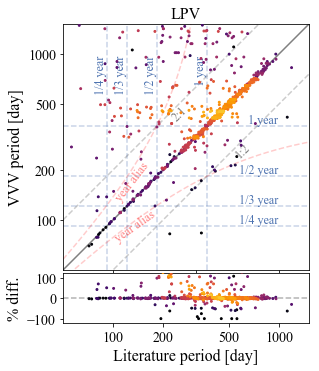

In [37]:
ax=make_one_to_one_plot(var_dataset_lF[(var_dataset_lF['var_class']=='LPV')&(var_dataset_lF['cat_period']>0.)],
                    xlim=[50.,1500.1],bins=60,literature='LPV',points=True,
                    year_alias_label=True)
plt.sca(ax[0]);
add_year_alias_red();
add_year_G();
# add_alias_lines_G();
add_double_lines(np.log10(265.),np.log10(220.))
plt.annotate('year alias',
             xy=(np.log10(100.), np.log10(1. / (1. / 100. + 1. / 365.) + 25.)),
             fontsize=12.,
             rotation=35.,
             xycoords='data',
             alpha=0.5,
             color='r')
plt.annotate('year alias',
             xy=(np.log10(100.), np.log10(1. / (1. / 100. - 1. / 365.) + 65.)),
             fontsize=12.,
             rotation=52.,
             xycoords='data',
             alpha=0.5,
             color='r')

plt.savefig('period_1to1_lpv.pdf',bbox_inches='tight',dpi=300)

/data/jls/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10


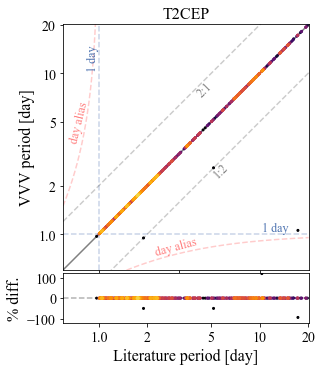

In [103]:
ax=make_one_to_one_plot(var_dataset_lF[(var_dataset_lF['var_class']=='T2CEP')],
                    xlim=[0.6,20.1],bins=100,literature='T2CEP',
                    points=True)
plt.sca(ax[0]);#add_alias_lines_G()
add_double_lines(np.log10(2.5),np.log10(4.))
add_day_alias_red()
add_hline(1.)
add_vline(1.)
add_annotate('1 day', 15., 1.)
plt.annotate('day alias',
             xy=(np.log10(2.2), np.log10(1. / (1. / .5 + 1. / 1.) + .53)),
             fontsize=12.,
             rotation=15.,
             xycoords='data',
             alpha=0.5,
             color='r')
plt.annotate('day alias',
             xy=(np.log10(0.65), np.log10(1. / (1. / .5 - 1. / 1.) + 5.)),
             fontsize=12.,
             rotation=76.,
             xycoords='data',
             alpha=0.5,
             color='r')

plt.savefig('period_1to1_t2cep.pdf',bbox_inches='tight',dpi=300)

/data/jls/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10


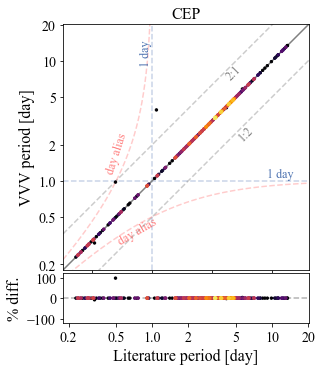

In [36]:
ax=make_one_to_one_plot(var_dataset_lF[(var_dataset_lF['var_class']=='CEP')&(var_dataset_lF['cat_period']>0.)],
                    xlim=[0.18,20.1],bins=100,literature='CEP',
                    points=True)
plt.sca(ax[0]);#add_alias_lines_G()
add_double_lines(np.log10(2.5),np.log10(4.))
add_day_alias_red()
add_hline(1.)
add_vline(1.)
add_annotate('1 day', 15., 1.)
plt.annotate('day alias',
             xy=(np.log10(.5), np.log10(1. / (1. / .5 + 1. / 1.) + .1)),
             fontsize=12.,
             rotation=30.,
             xycoords='data',
             alpha=0.5,
             color='r')
plt.annotate('day alias',
             xy=(np.log10(.4), np.log10(1. / (1. / .5 - 1. / 1.) + 1.2)),
             fontsize=12.,
             rotation=72.,
             xycoords='data',
             alpha=0.5,
             color='r')

plt.savefig('period_1to1_cep.pdf',bbox_inches='tight',dpi=300)

/data/jls/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10
/data/jls/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10


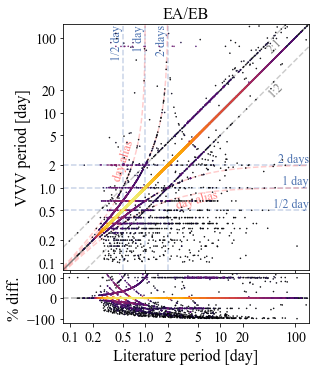

In [105]:
ax=make_one_to_one_plot(var_dataset_lF[var_dataset_lF['var_class']=='EA/EB'],
                    xlim=[0.08,150.1],bins=200,literature='EA/EB',
                    points=True)
plt.sca(ax[0])
add_double_lines(np.log10(20.5),np.log10(40.))
add_day_alias_red()
add_hline(1.)
add_vline(1.)
add_annotate('1 day', 150., 1.)

add_hline(.5)
add_vline(.5)
add_annotate('1/2 day', 150., .5)

add_hline(2.)
add_vline(2.)
add_annotate('2 days', 150., 2.)

plt.annotate('day alias',
             xy=(np.log10(2.5), np.log10(1. / (1. / .5 + 1. / 1.) + .4)),
             fontsize=12.,
             rotation=15.,
             xycoords='data',
             alpha=0.5,
             color='r')
plt.annotate('day alias',
             xy=(np.log10(.35), np.log10(1. / (1. / .5 - 1. / 1.) + 2.5)),
             fontsize=12.,
             rotation=72.,
             xycoords='data',
             alpha=0.5,
             color='r')
add_half_day_alias_red()
plt.savefig('period_1to1_eaeb.pdf',bbox_inches='tight',dpi=300)

/data/jls/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10
/data/jls/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10


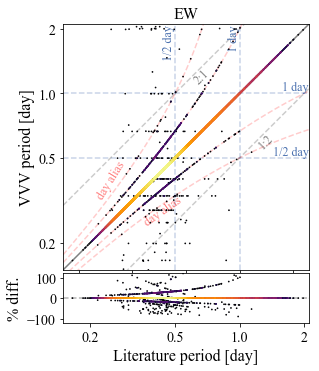

In [106]:
ax=make_one_to_one_plot(var_dataset_lF[var_dataset_lF['var_class']=='EW'],
                    xlim=[0.15,2.1],bins=100,literature='EW',
                    points=True)

plt.sca(ax[0])
add_double_lines(np.log10(0.6),np.log10(0.6))
add_day_alias_red()
add_hline(1.)
add_vline(1.)
add_annotate('1 day', 2.1, 1.)

add_hline(.5)
add_vline(.5)
add_annotate('1/2 day', 2.1, .5)

add_half_day_alias_red()

plt.annotate('day alias',
             xy=(np.log10(0.35), np.log10(1. / (1. / .5 + 1. / 1.) -0.025)),
             fontsize=12.,
             rotation=35.,
             xycoords='data',
             alpha=0.5,
             color='r')
plt.annotate('day alias',
             xy=(np.log10(.21), np.log10(1. / (1. / .5 - 1. / 1.) -0.55)),
             fontsize=12.,
             rotation=58.,
             xycoords='data',
             alpha=0.5,
             color='r')
plt.savefig('period_1to1_ew.pdf',bbox_inches='tight',dpi=300)

/data/jls/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10
/data/jls/python3.5/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10


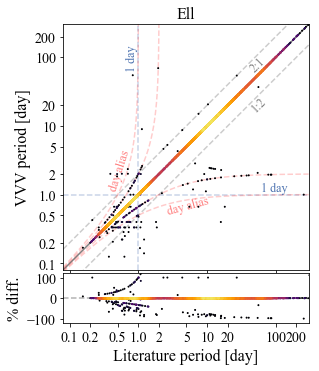

In [107]:
ax=make_one_to_one_plot(var_dataset_lF[var_dataset_lF['var_class']=='Ell'],
                    xlim=[0.08,300.1],bins=100,literature='Ell',
                    points=True)
plt.sca(ax[0])
add_double_lines(np.log10(20.5),np.log10(40.))
add_day_alias_red()
add_hline(1.)
add_vline(1.)
add_annotate('1 day', 150., 1.)

add_half_day_alias_red()

plt.annotate('day alias',
             xy=(np.log10(2.5), np.log10(1. / (1. / .5 + 1. / 1.) + .4)),
             fontsize=12.,
             rotation=15.,
             xycoords='data',
             alpha=0.5,
             color='r')
plt.annotate('day alias',
             xy=(np.log10(.35), np.log10(1. / (1. / .5 - 1. / 1.) + 2.5)),
             fontsize=12.,
             rotation=72.,
             xycoords='data',
             alpha=0.5,
             color='r')

plt.savefig('period_1to1_ell.pdf',bbox_inches='tight',dpi=300)

/data/jls/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10


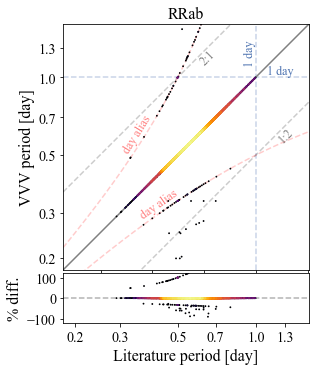

In [237]:
ax=make_one_to_one_plot(var_dataset_lF[var_dataset_lF['var_class']=='RRab'],
                    xlim=[0.18,1.6],bins=100,literature='RRab',points=True,
                    ticks=np.array([0.2,0.3,0.5,0.7,1.,1.3]))
plt.sca(ax[0])
add_double_lines(np.log10(0.6),np.log10(0.6))
add_day_alias_red()
add_hline(1.)
add_vline(1.)
add_annotate('1 day', 1.4, 1.)
plt.annotate('day alias',
             xy=(np.log10(0.35), np.log10(1. / (1. / .5 + 1. / 1.) + 0.015)),
             fontsize=12.,
             rotation=35.,
             xycoords='data',
             alpha=0.5,
             color='r')
plt.annotate('day alias',
             xy=(np.log10(.3), np.log10(1. / (1. / .5 - 1. / 1.) -0.33)),
             fontsize=12.,
             rotation=58.,
             xycoords='data',
             alpha=0.5,
             color='r')

plt.savefig('period_1to1_rrab.pdf',bbox_inches='tight',dpi=300)

/data/jls/python3.5/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10


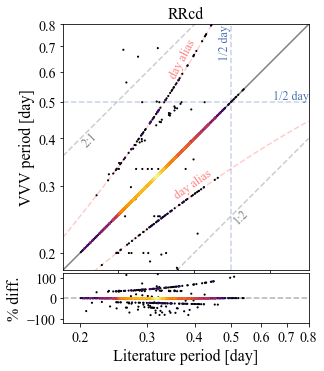

In [109]:
ax=make_one_to_one_plot(var_dataset_lF[var_dataset_lF['var_class']=='RRcd'],
                    xlim=[0.18,0.8],bins=100,literature='RRcd',points=True,
                    ticks=np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8]))
plt.sca(ax[0])
add_double_lines(np.log10(0.25),np.log10(0.2))
add_day_alias_red()
add_hline(.5)
add_vline(.5)
add_annotate('1/2 day', 0.8, .5)
plt.annotate('day alias',
             xy=(np.log10(0.35), np.log10(1. / (1. / .5 + 1. / 1.) -0.015)),
             fontsize=12.,
             rotation=35.,
             xycoords='data',
             alpha=0.5,
             color='r')
plt.annotate('day alias',
             xy=(np.log10(.34), np.log10(1. / (1. / .5 - 1. / 1.) -0.3)),
             fontsize=12.,
             rotation=62.,
             xycoords='data',
             alpha=0.5,
             color='r')

plt.savefig('period_1to1_rrcd.pdf',bbox_inches='tight',dpi=300)

In [43]:
import sys
sys.path.append('../')
from config import configuration
config = configuration()
config.request_password()

def get_lightcurve(sourceid):

    lcs = pd.DataFrame(sqlutilpy.get('''
                                select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_train_zyjhk where sourceid={0}'''.format(sourceid),
                     **config.wsdb_kwargs))
    
    if len(lcs)==0:

        lcs = pd.DataFrame(sqlutilpy.get('''
                                    select sourceid, 
                                    unnest(mjdobs) as mjdobs,
                                    unnest(mag) as mag,
                                    unnest(emag) as emag,
                                    unnest(filterid) as filterid,
                                    unnest(chi) as chi,
                                    unnest(ast_res_chisq) as ast_res_chisq,
                                    unnest(ambiguous_match) as ambiguous_match  
                                    from leigh_smith.virac2_ts_tmolnar_variables where sourceid={0}'''.format(sourceid),
                         **config.wsdb_kwargs))
    
    return lcs


 ·············


In [47]:
import sys
import sqlutilpy
sys.path.append('../')
from fine_classif.feat_extract.compute_feats import correct_to_HJD, fourier_poly_chi2_fit_full, \
    retrieve_fourier_poly, LombScargle
from fine_classif.feat_extract.compute_feats import sigclipper, \
optimum_regularization, check_significant_second_minimum, find_phase_of_minimum

In [55]:
def plot_lightcurve(clss='RRab',ii=105,ax=None,reg=True):
    fltr = (var_dataset['class']==clss)&(var_dataset['prob']>0.9)&(var_dataset['ks_b_ivw_mean_mag']<14.)
    sid,per,clss=var_dataset['sourceid'].values[fltr][ii],period_fix(var_dataset)[fltr][ii],var_dataset['class'].values[fltr][ii]
    cper = var_dataset['cat_period'].values[fltr][ii]
    prb = var_dataset['prob'].values[fltr][ii]
    print(var_dataset['var_class'].values[fltr][ii])
    print('LSQ period', var_dataset['lsq_period'].values[fltr][ii])
    print(var_dataset['significant_second_minimum'].values[fltr][ii])
    print('corrected LSQ period', period_fix(var_dataset)[fltr][ii])
    print(sid)
    print('Cat period', cper)
    results_d, lc=plot_lc_sid(sid, var_dataset['ra'].values[ii], var_dataset['dec'].values[ii],per,
                var_dataset['lsq_nterms'].values[ii], cper, ax=ax, reg=reg)
    plt.title('%s, classif. prob.=%0.4f'%(clss,prb),loc='left',fontsize=18)
    return results_d, lc
    
def plot_lc_sid(sid,ra,dec,per,nterms,cper,ax=None,reg=True):
    lc=get_lightcurve(sid)
    clean = (lc['filterid']==5)&(lc['ambiguous_match']==0)&(lc['ast_res_chisq']<13.)&(lc['chi']<5.)
    lc = sigclipper(lc[clean])

    correct_to_HJD(lc,
                 ra,
                 dec)

    tt = lc['HJD'].values[np.argmin(np.abs(lc['mag'].values-np.nanpercentile(lc['mag'],98.)))]

    model = LombScargle(lc['HJD'].values-tt, lc['mag'].values, 
                        lc['emag'].values, normalization='standard')
    freq, power = model.autopower(maximum_frequency=10.)

    if ax is None:
        f,ax=plt.subplots(2,1,figsize=[5.,5.5],gridspec_kw={'height_ratios':[1.,0.3]})
    plt.sca(ax[0])
    plt.errorbar((((lc['HJD'].values-tt)%(2.*per))/per),
                 lc['mag'].values,
                 yerr=lc['emag'].values,fmt='o',color='gray',mew=0.5,mec='k')
#     plt.ylim(np.nanmean(lc['mag'].values)-0.3,np.nanmean(lc['mag'].values)+0.3)
    plt.gca().invert_yaxis()
    plt.xlim(-0.1,2.1)
    # plt.ylim(-0.5,0.5)
    plt.xlabel('Phase')
    plt.ylabel(r'$K_s$ [mag]')
#     nterms=combo_dset['lsq_nterms'].values[fltr][ii]
    opt_reg=0
    if reg:
        opt_reg=optimum_regularization(lc['mag'].values, lc['emag'].values)
    print(opt_reg)
    results_d = fourier_poly_chi2_fit_full(
                                             times=lc['HJD'].values-tt,
                                             mag=lc['mag'].values,
                                             err=lc['emag'].values,
                                             freq_dict={'freq_grid':np.array([1./per])},
                                             nterms=np.int64(nterms),
                                             npoly=3,
                                             regularization=opt_reg,
                                             time_zeropoint_poly=0.,
                                             regularize_by_trace = True,
                                             check_multiples=False, 
                                             use_power_of_2=False,
                                             return_period_error=False)
    print(find_phase_of_minimum(results_d))
    print(check_significant_second_minimum(results_d, 
                                          find_phase_of_minimum(results_d)))
    
    xx=np.linspace(-0.1*per,2.1*per,1000)
    FF = retrieve_fourier_poly(xx,
                               results_d)
    plt.plot(xx/per, FF,color='#FFA500',lw=3)

    plt.sca(ax[1])
    plt.plot(1./freq,power,color='#FFA500',lw=0.6)
    plt.xlim(np.max([per*0.2,0.1]),per*5.)
    plt.semilogx()

    plt.gca().xaxis.set_major_locator(LogLocator(subs=(0.5,1.,2.)))
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())

    plt.axvline(per,color='gray',ls='dashed',alpha=0.5,lw=3,zorder=-10)
    plt.axvline(per/2.,color='gray',ls='dashed',alpha=0.2,lw=3,zorder=-10)

    plt.annotate('Period=%0.4f days'%per,xy=(0.98,0.95),ha='right',va='top',xycoords='axes fraction',
                fontsize=15)
    
    plt.xlabel('Period [days]')
    plt.ylabel('LS Power')
    plt.ylim(0.,)
    plt.subplots_adjust(hspace=0.32)
    plt.sca(ax[0])
    
#     plt.figure()
#     plt.errorbar((((lc['HJD'].values-tt))),
#                  lc['mag'].values,
#                  yerr=lc['emag'].values,fmt='o',color='gray',mew=0.5,mec='k')
#     plt.gca().invert_yaxis()
#     plt.xlabel('Phase')
#     plt.ylabel(r'$K_s$ [mag]')
#     xx = np.linspace(*np.nanpercentile(lc['HJD'].values-tt,[0.,100.]),1000)
#     FF = retrieve_fourier_poly(xx,
#                                results_d)
#     plt.plot(xx, FF,color='#FFA500',lw=3)
    
#     plt.figure()
#     plt.errorbar((((lc['HJD'].values-tt) % (2.*cper))),
#                  lc['mag'].values,
#                  yerr=lc['emag'].values,fmt='o',color='gray',mew=0.5,mec='k')
#     plt.gca().invert_yaxis()
# #     plt.xlim(-0.1,2.1)
#     # plt.ylim(-0.5,0.5)
#     plt.xlabel('Phase')
#     plt.ylabel(r'$K_s$ [mag]')
#     opt_reg=0
#     if reg:
#         opt_reg=optimum_regularization(lc['mag'].values, lc['emag'].values)
#     print(opt_reg)
#     results_d = fourier_poly_chi2_fit_full(
#                                              times=lc['HJD'].values-tt,
#                                              mag=lc['mag'].values,
#                                              err=lc['emag'].values,
#                                              freq_dict={'freq_grid':np.array([1./cper])},
#                                              nterms=np.int64(nterms),
#                                              npoly=3,
#                                              regularization=opt_reg,
#                                              time_zeropoint_poly=0.,
#                                              regularize_by_trace = True,
#                                              check_multiples=False, 
#                                              use_power_of_2=False,
#                                              return_period_error=False)
    
#     xx=np.linspace(-0.1*cper,2.1*cper,1000)
# #     xx = np.linspace(*np.nanpercentile(lc['HJD'].values-tt,[0.,100.]),1000)
#     FF = retrieve_fourier_poly(xx,
#                                results_d)
#     plt.plot(xx, FF,color='#FFA500',lw=3)
    return results_d, lc
    # plt.plot((lc['mjdobs'][clean]%(cper)/cper),lc['mag'][clean]-np.nanmedian(lc['mag'][clean]),'.')

In [4]:
for ii in ['EW','EA/EB','RRab','RRcd','Ell','CEP','T2CEP','LPV']:
    fltr = (np.abs(var_dataset_lF['cat_period'].values/period_fix(var_dataset_lF)-1)>0.001)\
    &(var_dataset_lF['var_class']==ii)&(var_dataset_lF['cat_period']>0.)
    print(ii,'%0.2f'%(100*np.count_nonzero(fltr)/
                      np.count_nonzero((var_dataset_lF['var_class']==ii)&(var_dataset_lF['log10_fap_ls']<-10)&(var_dataset_lF['cat_period']>0.))))

/data/jls/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


EW 1.77
EA/EB 2.94
RRab 0.58
RRcd 3.80
Ell 4.39
CEP 2.95
T2CEP 4.81
LPV 96.53


In [16]:
for ii in ['EW','EA/EB','RRab','RRcd','Ell','CEP','T2CEP','LPV']:
    fltr = (np.abs(var_dataset_lF['cat_period'].values/period_fix(var_dataset_lF)-1)>0.1)\
    &(var_dataset_lF['var_class']==ii)&(var_dataset_lF['cat_period']>0.)
    print(ii,'%0.2f'%(100*np.count_nonzero(fltr)/
                      np.count_nonzero((var_dataset_lF['var_class']==ii)&(var_dataset_lF['log10_fap_ls']<-10)&(var_dataset_lF['cat_period']>0.))))

/data/jls/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


EW 1.71
EA/EB 2.74
RRab 0.56
RRcd 3.64
Ell 1.61
CEP 0.66
T2CEP 1.09
LPV 32.00


In [57]:
for ii in ['EW','EA/EB','RRab','RRcd','Ell','CEP','T2CEP','LPV']:
    fltr = (np.abs(var_dataset_full['cat_period'].values/period_fix(var_dataset_full)-1)>0.1)\
    &(var_dataset_full['var_class']==ii)
    print(ii,'%0.2f'%(100*np.count_nonzero(fltr)/
                      np.count_nonzero((var_dataset_full['var_class']==ii))))

/data/jls/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


EW 24.33
EA/EB 41.83
RRab 6.00
RRcd 24.34
Ell 25.49
CEP 6.04
T2CEP 2.68
LPV 64.00


In [100]:
for ii in ['EW','EA/EB','RRab','RRcd','Ell','CEP','T2CEP','LPV']:
    fltr = (np.abs(var_dataset['cat_period'].values/period_fix(var_dataset)-1)>0.1)\
    &(var_dataset['var_class']==ii)
    print(ii,'%0.2f'%(100*np.count_nonzero(fltr)/
                      np.count_nonzero((var_dataset['var_class']==ii))))

/data/jls/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


EW 1.71
EA/EB 2.74
RRab 0.56
RRcd 3.62
Ell 1.62
CEP 0.99
T2CEP 0.93
LPV 35.85


In [110]:
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_training_set.pkl', 'rb') as f:
    var_dataset_scaled_tmp = pickle.load(f)

In [ ]:
# plot_lightcurve('EW',51,ax[:2,0])
# plot_lightcurve('EA/EB',51,ax[:2,1])
# plot_lightcurve('RRab',51,ax[:2,2])
# plot_lightcurve('RRcd',58,ax[:2,3])
# plot_lightcurve('Ell',52,ax[3:5,0])
# plot_lightcurve('CEP',53,ax[3:5,1])
# plot_lightcurve('T2CEP',53,ax[3:5,2])
# plot_lightcurve('LPV',-14,ax[3:5,3])

# plot_lightcurve('EW',54,ax[:2,0])
# plot_lightcurve('EA/EB',84,ax[:2,1])
# plot_lightcurve('RRab',52,ax[:2,2])
# plot_lightcurve('RRcd',67,ax[:2,3])
# plot_lightcurve('Ell',52,ax[3:5,0])
# plot_lightcurve('CEP',74,ax[3:5,1])
# plot_lightcurve('T2CEP',83,ax[3:5,2])
# plot_lightcurve('LPV',736,ax[3:5,3])

In [190]:
fltr_tmp = (var_dataset_scaled_tmp['class']=='EA/EB')&(var_dataset_scaled_tmp['prob']>0.9)&(var_dataset_scaled_tmp['ks_b_ivw_mean_mag']<14.)
fltr = (var_dataset['class']=='EA/EB')&(var_dataset['prob']>0.9)&(var_dataset['ks_b_ivw_mean_mag']<14.)
np.argwhere(var_dataset[fltr]['sourceid'].values==var_dataset_scaled_tmp[fltr_tmp]['sourceid'].values[51])

array([[84]])

EW
LSQ period 0.37697295849497614
True
corrected LSQ period 0.37697295849497614
8700903005463
Cat period 0.3769721
4.506333279015417e-05
0.4994994994994995
True
EA/EB
LSQ period 2.948795561535579
True
corrected LSQ period 2.948795561535579
8512503000864
Cat period 2.9486869
0.00014424524314922952
0.994994994994995
True
RRab
LSQ period 0.6613078910388692
False
corrected LSQ period 0.6613078910388692
8582129003230
Cat period 0.66130864
0.00042193478258856546
0.9629629629629629
False
RRcd
LSQ period 0.29567669872871605
False
corrected LSQ period 0.29567669872871605
9225274009892
Cat period 0.2956757
0.010543861453061803
0.007007007007007007
False
Ell
LSQ period 7.340629305374474
False
corrected LSQ period 14.681258610748948
8492023004837
Cat period 14.6809334
0.003508556408832236
0.995995995995996
True
CEP
LSQ period 3.188889981070742
False
corrected LSQ period 3.188889981070742
11658496011069
Cat period 3.1888776
0.0013983589016236236
0.012012012012012012
False
T2CEP
LSQ period 1.9307169

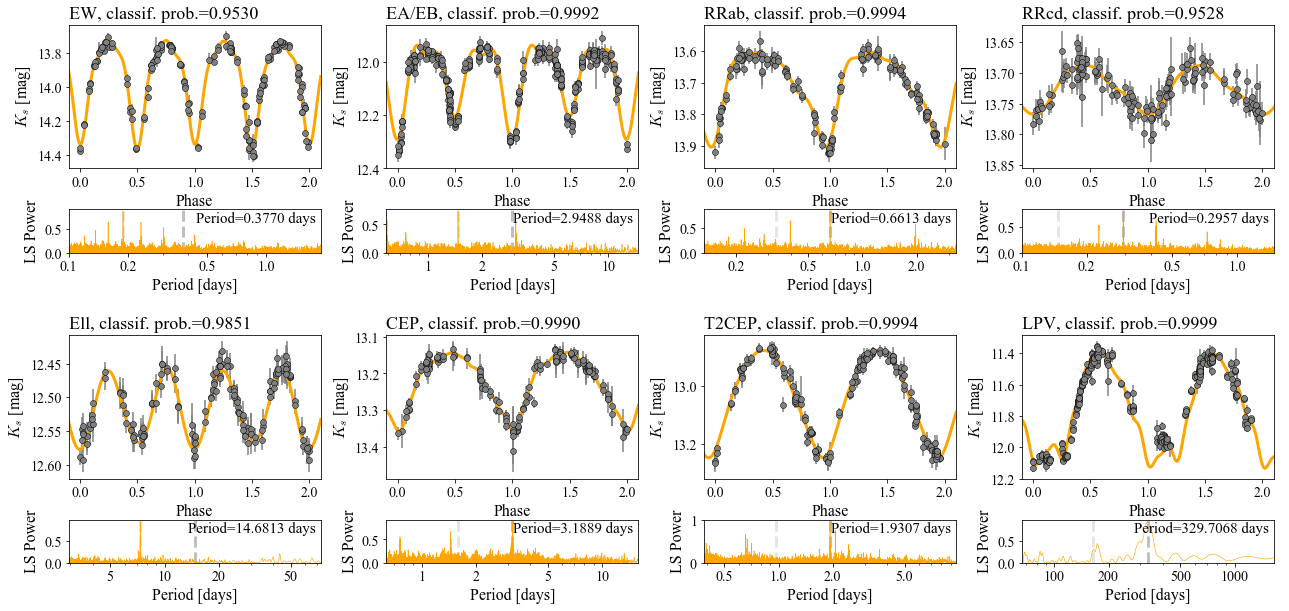

In [235]:
f,ax=plt.subplots(5,4,figsize=[24.*0.9,5.5*2*0.9],gridspec_kw={'height_ratios':[1.,0.3,0.0,1.,0.3]})
for ii in ax[2]:
    ii.axis('off')
plot_lightcurve('EW',54,ax[:2,0])
plot_lightcurve('EA/EB',83,ax[:2,1])
plot_lightcurve('RRab',52,ax[:2,2])
plot_lightcurve('RRcd',95,ax[:2,3])
plot_lightcurve('Ell',52,ax[3:5,0])
plot_lightcurve('CEP',74,ax[3:5,1])
plot_lightcurve('T2CEP',52,ax[3:5,2])
plot_lightcurve('LPV',736,ax[3:5,3])
plt.subplots_adjust(wspace=0.26,hspace=0.55)
plt.savefig('training_set_examples.pdf',bbox_inches='tight')

/data/jls/python3.5/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


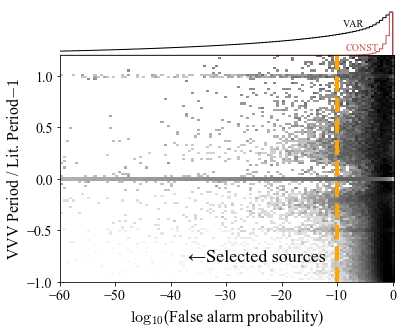

In [74]:
from plotting_general import col_norm, row_norm
f,a=plt.subplots(2,1,figsize=[6.,5.],
                gridspec_kw={'height_ratios':[0.2,1.]},
                sharex=True)
plt.subplots_adjust(hspace=0.)
plt.sca(a[0]);plt.axis('off')
fltr = (var_dataset_full['var_class']!='CONST')
plt.hist(var_dataset_full['log10_fap_ls'][fltr],
        range=[-360,0],histtype='step',bins=np.int(100/60*360),
        lw=1,color='k',cumulative=True,density=True)
fltr = (var_dataset_full['var_class']=='CONST')
plt.hist(var_dataset_full['log10_fap_ls'][fltr],
        range=[-360,0],histtype='step',bins=np.int(100/60*360),
        lw=1,color=sns.color_palette()[2],cumulative=True,density=True)
# plt.xlim(-60.,0.)
plt.ylim(0.,)
plt.annotate('CONST',xy=(-8.4,0.12),color=sns.color_palette()[2])
plt.annotate('VAR',xy=(-9,0.66),color='k')
# plt.semilogy()
plt.sca(a[1])
fltr = (var_dataset_full['var_class']!='CONST')
row_norm(var_dataset_full['log10_fap_ls'][fltr],
         (period_fix(var_dataset_full)/var_dataset_full['cat_period']-1)[fltr],
        range=[[-60,0.3],[-1.,1.2]],bins=110,norm=LogNorm(),
        cmap=plt.cm.Greys);
import seaborn as sns
plt.axvline(-10,ls='dashed',color='#FFA500',lw=4)
plt.annotate('←Selected sources',xy=(-12,-0.8),ha='right',
            fontsize=18)
plt.xlabel('$\log_{10}$(False alarm probability)')
plt.ylabel(r'VVV Period / Lit. Period$-1$')
plt.savefig('log10fapcut.pdf',bbox_inches='tight')

In [75]:
ew = var_dataset_lF[(var_dataset_lF['var_class']=='EW')].reset_index(drop=True)
eaebNS = var_dataset_lF[(var_dataset_lF['var_class']=='EA/EB')&
                  ~(var_dataset_lF['significant_second_minimum'])].reset_index(drop=True)
eaebS = var_dataset_lF[(var_dataset_lF['var_class']=='EA/EB')&
                  (var_dataset_lF['significant_second_minimum'])].reset_index(drop=True)

/data/jls/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/jls/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


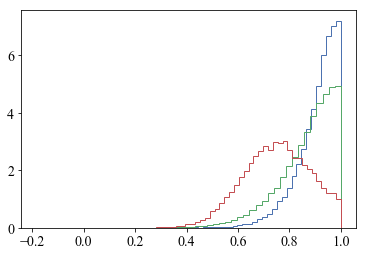

In [76]:
plt.hist(ew['peak_ratio_data'],density=True,histtype='step',bins=50)
plt.hist(eaebNS['peak_ratio_data'],density=True,histtype='step',bins=50);
plt.hist(eaebS['peak_ratio_data'],density=True,histtype='step',bins=50);

/data/jls/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'contours', 'label'
  s)


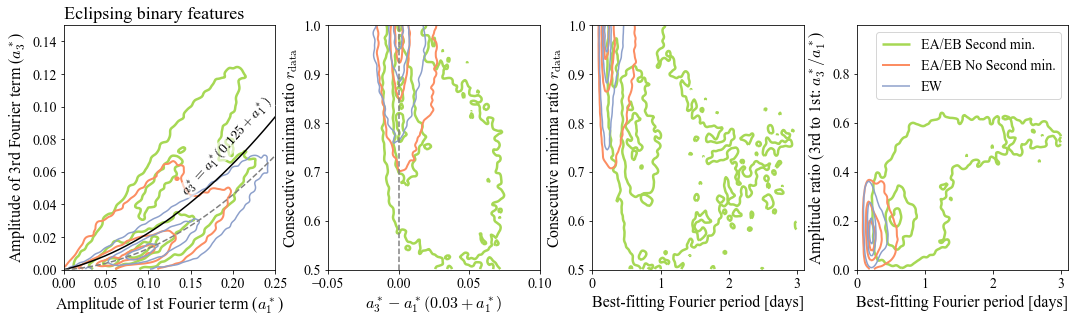

In [77]:
f,a=plt.subplots(1,4,figsize=[18.,4.5])

plt.sca(a[0])
for ii,(lbl,dd) in enumerate(zip(['EA/EB','E2','EW'],[eaebS,eaebNS,ew])):
    nn, x, y = np.histogram2d(
        dd['amp_double_1'],
        dd['amp_double_3']
        ,bins=200,range=[[0.,0.3],[0.,0.15]])
    import seaborn as sns
    from scipy.ndimage import gaussian_filter
    colors = [sns.color_palette('Set2')[4],sns.color_palette('Set2')[1]
             ,sns.color_palette('Set2')[2]]
    nn=gaussian_filter(nn.T,2.)
    c = plt.contour(.5*(x[1:]+x[:-1]),.5*(y[1:]+y[:-1]),nn,
                         origin='lower',
                         colors=[colors[ii]],
                         label=lbl,
                         contours=10,
                           levels=[np.max(nn)/10.,np.max(nn)/2.,np.max(nn)/1.2],
                   linewidths=2.5-ii*0.5)
    c.collections[0].set_label(lbl)
# plt.legend()
xx = np.linspace(0.,0.4)
plt.plot(xx,xx*(0.125+xx),color='k')
plt.xlim(0.,0.25)
plt.ylim(0.,0.15)
plt.xlabel('Amplitude of 1st Fourier term ($a^*_1$)')
plt.ylabel('Amplitude of 3rd Fourier term ($a^*_3$)')
plt.plot(xx,xx*(0.03+xx),color='gray',ls='dashed')
t=plt.annotate('$a^*_3=a^*_1(0.125+a^*_1)$',xy=(0.134,0.1005),rotation=48,fontsize=14)
t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='None',boxstyle='square,pad=0'))
plt.sca(a[1])
for ii,(lbl,dd) in enumerate(zip(['EA/EB Second min.','EA/EB No Second min.','EW'],[eaebS,eaebNS,ew])):
    nn, x, y = np.histogram2d(
        dd['amp_double_3']-dd['amp_double_1']*(0.03+dd['amp_double_1']),
        dd['peak_ratio_data']
        ,bins=200,range=[[-0.05,0.1],[0.5,1.]])
    import seaborn as sns
    from scipy.ndimage import gaussian_filter
    colors = [sns.color_palette('Set2')[4],sns.color_palette('Set2')[1]
             ,sns.color_palette('Set2')[2]]
    nn=gaussian_filter(nn.T,2.)
    c = plt.contour(.5*(x[1:]+x[:-1]),.5*(y[1:]+y[:-1]),nn,
                         origin='lower',
                         colors=[colors[ii]],
                         label=lbl,
                         contours=10,
                           levels=[np.max(nn)/10.,np.max(nn)/2.,np.max(nn)/1.2],
                   linewidths=2.5-ii*0.5)
    c.collections[0].set_label(lbl)
plt.xlabel('$a^*_3-a^*_1(0.03+a^*_1)$')
plt.ylabel(r'Consecutive minima ratio $r_\mathrm{data}$')
# plt.legend()
plt.axvline(0.,color='gray',ls='dashed')

plt.ylim(0.5,1.)
plt.xlim(-0.05,0.1)

plt.sca(a[2])
for ii,(lbl,dd) in enumerate(zip(['EA/EB Second min.','EA/EB No Second min.','EW'],[eaebS,eaebNS,ew])):
    nn, x, y = np.histogram2d(
        dd['lsq_period'],
        dd['peak_ratio_data']
        ,bins=200,range=[[0.,3.],[0.5,1.]])
    import seaborn as sns
    from scipy.ndimage import gaussian_filter
    colors = [sns.color_palette('Set2')[4],sns.color_palette('Set2')[1]
             ,sns.color_palette('Set2')[2]]
    nn=gaussian_filter(nn.T,2.)
    c = plt.contour(.5*(x[1:]+x[:-1]),.5*(y[1:]+y[:-1]),nn,
                         origin='lower',
                         colors=[colors[ii]],
                         label=lbl,
                         contours=10,
                           levels=[np.max(nn)/10.,np.max(nn)/2.,np.max(nn)/1.2],
                   linewidths=2.5-ii*0.5)
    c.collections[0].set_label(lbl)
plt.xlabel('Best-fitting Fourier period [days]')
plt.ylabel(r'Consecutive minima ratio $r_\mathrm{data}$')
# plt.legend()
plt.xlim(0.,3.1)
plt.ylim(0.5,1.)

plt.sca(a[3])
for ii,(lbl,dd) in enumerate(zip(['EA/EB Second min.','EA/EB No Second min.','EW'],[eaebS,eaebNS,ew])):
    nn, x, y = np.histogram2d(
        dd['lsq_period'],
        dd['amp_double_3']/dd['amp_double_1'],
        bins=200,range=[[0.,3.],[0.,1.]])
    import seaborn as sns
    from scipy.ndimage import gaussian_filter
    colors = [sns.color_palette('Set2')[4],sns.color_palette('Set2')[1]
             ,sns.color_palette('Set2')[2]]
    nn=gaussian_filter(nn.T,2.)
    c = plt.contour(.5*(x[1:]+x[:-1]),.5*(y[1:]+y[:-1]),nn,
                         origin='lower',
                         colors=[colors[ii]],
                         label=lbl,
                         contours=10,
                           levels=[np.max(nn)/10.,np.max(nn)/2.,np.max(nn)/1.2],
                   linewidths=2.5-ii*0.5)
    c.collections[0].set_label(lbl)
plt.legend()
plt.xlabel('Best-fitting Fourier period [days]')
plt.ylabel('Amplitude ratio (3rd to 1st: $a^*_3/a^*_1$)')
plt.xlim(0.,3.1)
plt.ylim(0.,)
plt.sca(a[0])
plt.title('Eclipsing binary features',loc='left',fontsize=18)
plt.subplots_adjust(wspace=0.25)
plt.savefig('eclipsing_features.pdf',bbox_inches='tight')

## Period distribution

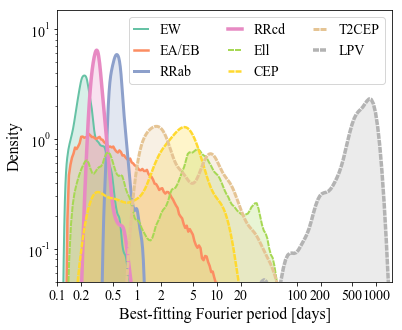

In [82]:
plt.figure(figsize=[6.,5.])
for ii,ll in enumerate(['EW','EA/EB','RRab','RRcd','Ell','CEP','T2CEP','LPV']):
    fll=np.log10(var_dataset_lF['lsq_period'][
        (var_dataset_lF['var_class']==ll)&(var_dataset_lF['lsq_period']<3000.)])
    ls='solid'
    if ii>3:
        ls=(0,(6/(2+(ii%4)*0.5),1/(2+(ii%4)*0.5)))
    sns.kdeplot(fll[(fll>np.nanpercentile(fll,1.))&(fll<np.nanpercentile(fll,99.5))],
            color=sns.color_palette('Set2')[ii],lw=2+(ii%4)*0.5,
            clip=[-2,3],label=ll,bw=(1./np.count_nonzero(fll))**.4,
               shade=0.01,ls=ls)
plt.semilogy()
plt.ylim(0.05,)
plt.xlim(-1,3.2)
plt.legend(ncol=3,handlelength=1)
plt.xlabel('Best-fitting Fourier period [days]')

ticks=[0.1,0.2,0.5,1,2,5,10,20,100,200,500,1000]
plt.xticks(np.log10(ticks),ticks);
plt.ylabel('Density')

plt.savefig('period_dist.pdf',bbox_inches='tight')

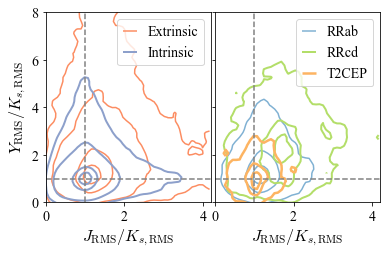

In [84]:
fltr1=np.any([(var_dataset_lF['var_class']==ll) for ll in ['EW','EA/EB','Ell']],
            axis=0)
fltr2=np.any([(var_dataset_lF['var_class']==ll) for ll in ['RRab','RRcd','CEP','T2CEP','LPV']],
            axis=0)
fltr3=np.any([(var_dataset_lF['var_class']==ll) for ll in ['RRcd']],
            axis=0)

fig,ax=plt.subplots(1,2,figsize=[6.,3.5],sharex=True,sharey=True)
for jj, ss in enumerate(['Y_model']):
    plt.sca(ax[0])
    for ii,(fltr,lbl) in enumerate(zip([fltr2,fltr1],['Extrinsic','Intrinsic'])):
        nn, x, y = np.histogram2d(
                var_dataset_lF['J_model'][fltr],
                   var_dataset_lF[ss][fltr],
                  range=[[-0.2,4.2],[-0.2,8.2]],bins=50);
        import seaborn as sns
        from scipy.ndimage import gaussian_filter
        colors = [sns.color_palette('Set2')[4],sns.color_palette('Set2')[1]
                 ,sns.color_palette('Set2')[2]]
        nn=gaussian_filter(nn.T,1.)
        c = plt.contour(.5*(x[1:]+x[:-1]),.5*(y[1:]+y[:-1]),nn,
                             origin='lower',
                             colors=[colors[ii+1]],
                             label=lbl,
                             contours=10,
                               levels=[np.max(nn)/50.,np.max(nn)/10.,
                                       np.max(nn)/2.,np.max(nn)*0.8],
                       linewidths=1.5+ii*0.5)
        c.collections[0].set_label(lbl)
    plt.axhline(1.,color='gray',ls='dashed')
    plt.axvline(1.,color='gray',ls='dashed')
    plt.legend(handlelength=1)
plt.xlabel(r'$J_\mathrm{RMS}/K_{s,\mathrm{RMS}}$')
plt.ylabel(r'$Y_\mathrm{RMS}/K_{s,\mathrm{RMS}}$')

for jj, ss in enumerate(['Y_model']):
    plt.sca(ax[1])
    for ii,f in enumerate(['RRab','RRcd','T2CEP']):
        fltr = (var_dataset_lF['var_class']==f)
        nn, x, y = np.histogram2d(
                var_dataset_lF['J_model'][fltr],
                   var_dataset_lF[ss][fltr],
                  range=[[-0.2,4.2],[-0.2,8.2]],bins=50);
        import seaborn as sns
        from scipy.ndimage import gaussian_filter
        colors = [sns.color_palette('Set2')[4],sns.color_palette('Set2')[1]
                 ,sns.color_palette('Set2')[2]]
        nn=gaussian_filter(nn.T,1.)
        indx=[4,6,5]
        c = plt.contour(.5*(x[1:]+x[:-1]),.5*(y[1:]+y[:-1]),nn,
                             origin='lower',
                             colors=[sns.color_palette('Set3')[indx[ii]]],
                             label=lbl,
                             contours=10,
                               levels=[np.max(nn)/10.,
                                       np.max(nn)/2.,
                                       np.max(nn)*0.8],
                       linewidths=1.5+ii*0.5)
        c.collections[0].set_label(f)
    plt.axhline(1.,color='gray',ls='dashed')
    plt.axvline(1.,color='gray',ls='dashed')
    plt.xlim(0.,4.2)
    plt.ylim(0.,8.)
    plt.legend(handlelength=1)
plt.subplots_adjust(wspace=0.02)
plt.xlabel(r'$J_\mathrm{RMS}/K_{s,\mathrm{RMS}}$')
plt.savefig('colour_scatter_measure.pdf',bbox_inches='tight')

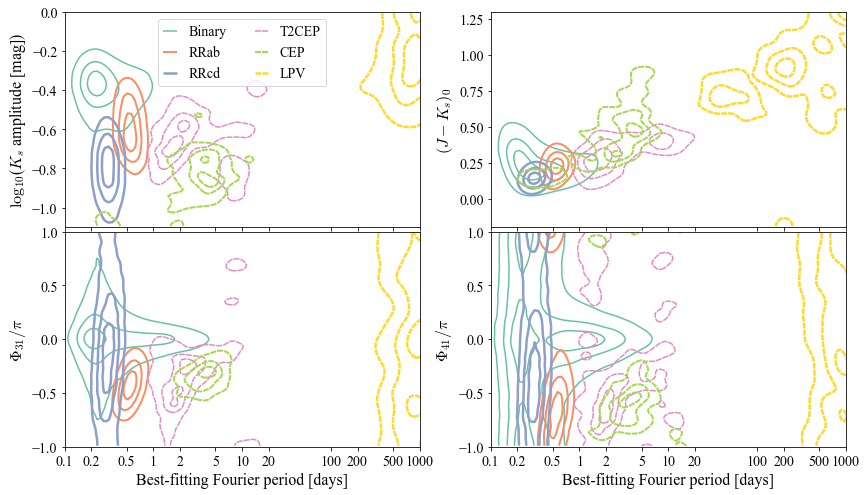

In [5]:
fig,ax=plt.subplots(2,2,figsize=[14.,8.],sharex=True)
plt.subplots_adjust(hspace=0.02)
ax = ax.flatten()
for jj,(col,ylbl,yrange) in enumerate(
    zip(['amplitude','JK_col','phi2_phi0','phi3_phi0'],
        [r'$\log_{10}$($K_s$ amplitude [mag])', r'$(J-K_s)_0$',
        r'$\Phi_{31}/\pi$',r'$\Phi_{41}/\pi$'],
        [[-1.1,-0.0],[-0.2,1.3],[-1,1],[-1,1]])):
    plt.sca(ax[jj])
    for ii,(f,lbl) in enumerate(
        zip([['EA/EB','EW','Ell'],['RRab'],['RRcd'],['T2CEP'],['CEP'],['LPV']],
        ['Binary','RRab','RRcd','T2CEP','CEP','LPV'])):
        fltr=np.any([(var_dataset_lF['var_class']==ll) for ll in f],axis=0)
        YY = var_dataset_lF[col][fltr]
        fold=True
        if col=='JK_col' or col=='HK_col' or col=='amplitude':
            fold=False
        if col=='amplitude':
            YY = np.log10(YY)
        if fold:
            YY = (YY - 2*np.pi*(YY>np.pi))/np.pi
        nn, x, y = np.histogram2d(
                np.log10(var_dataset_lF['lsq_period'][fltr]),
                YY,
                  range=[[-1+(f[0]=='LPV')*1.5,3.3],yrange],bins=100);
        import seaborn as sns
        from scipy.ndimage import gaussian_filter
        colors = [sns.color_palette('Set2')[4],sns.color_palette('Set2')[1]
                 ,sns.color_palette('Set2')[2]]
        nn=gaussian_filter(nn.T,2.+2.*(f[0]=='LPV'))
        c = plt.contour(.5*(x[1:]+x[:-1]),.5*(y[1:]+y[:-1]),nn,
                             origin='lower',
                             colors=[sns.color_palette('Set2')[ii]],
                             label=lbl,
                             contours=10,
                               levels=[
    #                                np.max(nn)/10.,
                                       np.max(nn)/5.,
                                       np.max(nn)/2.,
                                       np.max(nn)*0.8],
                       linewidths=1.5+(ii%3)*0.5)
        c.collections[0].set_label(lbl)
        if ii>2:
            for cp in c.collections:
                cp.set_dashes([(0, (6.0/(1.5+(ii%3)*0.5), 1.0/(1.5+(ii%3)*0.5)))])
        if jj==0:
            plt.legend(ncol=2,loc='upper center',handlelength=1.)
        plt.ylabel(ylbl)
        plt.ylim(*yrange)

        ticks=[0.1,0.2,0.5,1,2,5,10,20,100,200,500,1000]
        plt.xticks(np.log10(ticks),ticks);
        if jj>1:
            plt.xlabel('Best-fitting Fourier period [days]')
        plt.xlim(-1,3)
plt.savefig('period_amplitude.pdf',bbox_inches='tight')

## LPV inspection

In [87]:
fltr = (np.abs(var_dataset_lF['cat_period'].values/period_fix(var_dataset_lF)-1)>0.2)&(var_dataset_lF['var_class']=='LPV')
print(np.count_nonzero(fltr), np.count_nonzero((var_dataset_lF['var_class']=='LPV')))

250 785


/data/jls/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [88]:
import sqlutilpy
import time
def generate_lpv_plot(sid,per,cc='gray'):
    lc=get_lightcurve(sid)
    if(len(lc)<1):
        return False
    clean = (lc['filterid']==5)&(lc['ambiguous_match']==0)&(lc['ast_res_chisq']<13.)&(lc['chi']<5.)
    lc = sigclipper(lc[clean])
    if(len(lc)<1):
        return False

#     plt.errorbar((((lc['mjdobs'].values)%(2.*per))/per),
#                  lc['mag'].values,
#                  yerr=lc['emag'].values,fmt='o',color=cc,mew=0.5,mec='k')
#     plt.figure()
    model = LombScargle(lc['mjdobs'].values, lc['mag'].values, 
                        lc['emag'].values, normalization='standard')
    freq, power = model.autopower(maximum_frequency=20.,minimum_frequency=0.00066667)
#     plt.axvline(per,ymin=0.9,color='k')
#     plt.plot(1./freq, power)
#     plt.xlim(0.,1000.)
    
    topfreq = np.array(get_top_frequencies(lc['mjdobs'].values, lc['mag'].values, 
                        lc['emag'].values, freq, power, config, N=30)['top_distinct_freqs'])
    
    return np.any(np.abs(1./topfreq/per-1)<5e-2)

In [89]:
from fine_classif.feat_extract.lc_utils import get_top_frequencies
from fine_classif.feat_extract.compute_feats import source_feat_extract

In [92]:
fltr = (np.abs(var_dataset_lF['cat_period'].values/period_fix(var_dataset_lF)-1)>0.2)\
&(var_dataset_lF['var_class']=='LPV')&~(np.abs(var_dataset_lF['cat_period'].values/period_fix(var_dataset_lF)*2.-1)<0.2)

similar=[generate_lpv_plot(var_dataset_lF['sourceid'][fltr].values[ii],var_dataset_lF['cat_period'][fltr].values[ii]) 
            for ii in range(np.count_nonzero(fltr))]

/data/jls/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/data/jls/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/data/jls/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


In [94]:
np.count_nonzero(similar)

66

In [95]:
len(similar)

210

/data/jls/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


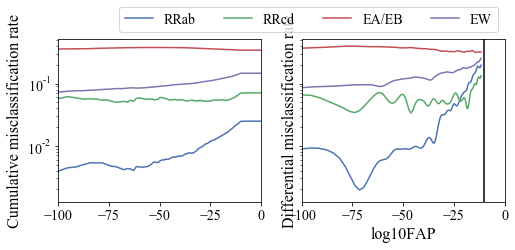

In [238]:
from scipy.ndimage import gaussian_filter1d

f,a=plt.subplots(1,2,figsize=[8.,3.],sharey=True,sharex=True)

for ii, kk in enumerate(['RRab','RRcd','EA/EB','EW']):
    bb = np.nanpercentile(var_dataset['log10_fap_ls'],np.linspace(0.,100.,150))
    n,b=np.histogram(var_dataset['log10_fap_ls'][(var_dataset['var_class']==kk)&~(var_dataset['class']==kk)],bins=bb)
    n2,b=np.histogram(var_dataset['log10_fap_ls'][(var_dataset['var_class']==kk)],bins=bb)
    plt.sca(a[0])
    plt.ylabel('Cumulative misclassification rate')
    plt.plot(.5*(b[1:]+b[:-1]),np.cumsum(n)/np.cumsum(n2),color=sns.color_palette(n_colors=8)[ii])
    plt.sca(a[1])
    plt.plot(.5*(b[1:]+b[:-1]),gaussian_filter1d(n/n2,2.),color=sns.color_palette(n_colors=8)[ii],
            label=kk)
    
plt.legend(ncol=4,bbox_to_anchor=(1.,1.),loc='lower right')
plt.semilogy()
plt.xlabel('log10FAP')
plt.ylabel('Differential misclassification rate')
plt.xlim(-100,0)
plt.axvline(-10,color='k')

In [98]:
import sqlutilpy
from config import configuration
config = configuration()
config.request_password()
rrl = pd.DataFrame(sqlutilpy.get('''select * from jason_sanders.virac2_variables where
class='CEP'
''',**config.wsdb_kwargs))

 ·············


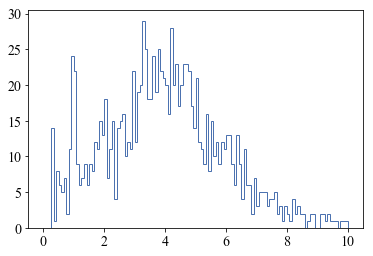

In [104]:
plt.hist(rrl['period'][rrl['prob']>0.9],range=[0,10.],bins=120,histtype='step');

(0.1, 2.0)

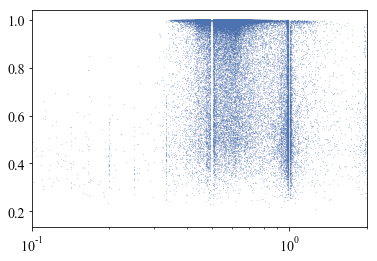

In [82]:
plt.plot(rrl['lsq_period'][rrl['class']=='RRab'],
         rrl['prob'][rrl['class']=='RRab'],'.',ms=0.2)
plt.semilogx()
plt.xlim(0.1,2.)